In [ ]:
from transformers import AutoTokenizer
import os
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [12]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
print(classifier("I absolutely love this product!"))



[{'label': 'POSITIVE', 'score': 0.9998854398727417}]


In [26]:
import pandas as pd
pathway = "/Users/hamidabdul/Library/CloudStorage/OneDrive-Personal/Projects/NLP/Code/sentiment-analyser/data/Reviews.csv"
df = pd.read_csv(pathway).rename(columns={"Text":"text"})
sample = df.sample(1000, random_state=42).copy()
  

In [25]:
clf = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1  # set to 0 if you have GPU
)

preds = clf(batch, truncation=True, padding=True) 

In [27]:
# Predict (make sure to truncate/pad)
preds = clf(sample["text"].tolist(), truncation=True, padding=True)
sample["pred_label"] = [p["label"] for p in preds]
sample["pred_score"] = [float(p["score"]) for p in preds]

In [28]:
output_pathway = "/Users/hamidabdul/Library/CloudStorage/OneDrive-Personal/Projects/NLP/Code/sentiment-analyser/results/reviews_sentiment_sample1k.csv"
sample.to_csv(output_pathway, index=False)
print("Saved → results/reviews_sentiment_sample1k.csv")

Saved → results/reviews_sentiment_sample1k.csv


In [29]:
print(sample["pred_label"].value_counts(normalize=True).round(3))
print(sample.sort_values("pred_score").head(5)[["text","pred_label","pred_score"]])         # least confident
print(sample.sort_values("pred_score", ascending=False).head(5)[["text","pred_label","pred_score"]])  # most confident


POSITIVE    0.688
NEGATIVE    0.312
Name: pred_label, dtype: float64
                                                     text pred_label  \
481393  I use jar foods when I am on the go or if I di...   NEGATIVE   
115627  Lipton Yellow Label is CTC (crush, tear, curl)...   POSITIVE   
492103  Waffle Crisp has been my favorite cereal since...   POSITIVE   
1533    Good product and decent shipping. However, the...   NEGATIVE   
145795  This is an excellent "everything but the kitch...   NEGATIVE   

        pred_score  
481393    0.500153  
115627    0.511091  
492103    0.517810  
1533      0.518081  
145795    0.535795  
                                                     text pred_label  \
544874  These gummy snacks are wonderful! They are in ...   POSITIVE   
563828  These cookies are delicious! So soft and flavo...   POSITIVE   
426110  Bought this for my daughter who loved flavored...   POSITIVE   
540558  Timothy's Midnight Magic coffee is the best K-...   POSITIVE   
304693  Exce

In [30]:
THRESH = 0.60
sample["uncertain"] = sample["pred_score"] < THRESH
sample["uncertain"].mean()  # share of low-confidence rows


0.021

 # Baseline model

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [47]:
def map_score(s):
    if s in [1, 2]:
        return 0  # Negative
    elif s == 3:
        return 1  # Neutral
    elif s in [4, 5]:
        return 2  # Positive

df["label"] = df["Score"].apply(map_score)

label2name = {0:"NEG", 1:"NEU", 2:"POS"}
df["label_name"] = df["label"].map(label2name)

In [48]:
print(df.shape)
print(df.head(3))
print(df.isna().mean().sort_values(ascending=False).head(10))
print(df.duplicated(subset=["text"]).sum(), "duplicate texts")

# drop exact duplicate texts if you want
# df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)


(568454, 12)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   

                 Summary                                               text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   

   label label_name  
0      2        POS  
1      0        NEG  
2      2        POS  
Summary             

NEG     82037
NEU     42640
POS    443777
Name: label_name, dtype: int64 

proportions:
 NEG    0.144
NEU    0.075
POS    0.781
Name: label_name, dtype: float64


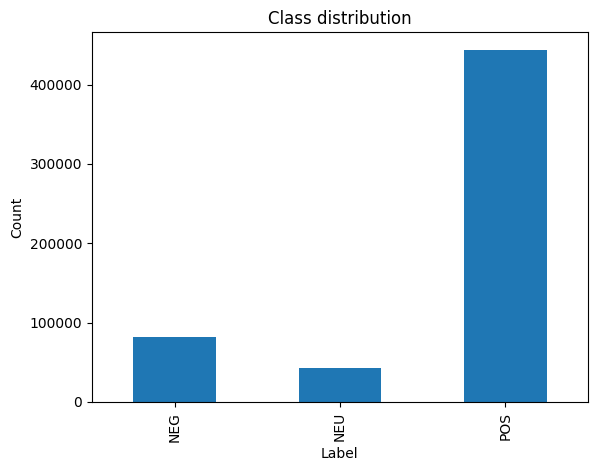

In [49]:
counts = df["label_name"].value_counts().reindex(["NEG","NEU","POS"]).fillna(0).astype(int)
print(counts, "\n\nproportions:\n", (counts / counts.sum()).round(3))

import matplotlib.pyplot as plt
plt.figure()
counts.plot(kind="bar")
plt.title("Class distribution")
plt.ylabel("Count")
plt.xlabel("Label")
plt.show()


        n_chars   n_words
count  568454.0  568454.0
mean      436.2      80.3
std       445.3      79.5
min        12.0       3.0
50%       302.0      56.0
90%       877.0     161.0
95%      1202.0     218.0
99%      2166.0     388.0
max     21409.0    3432.0


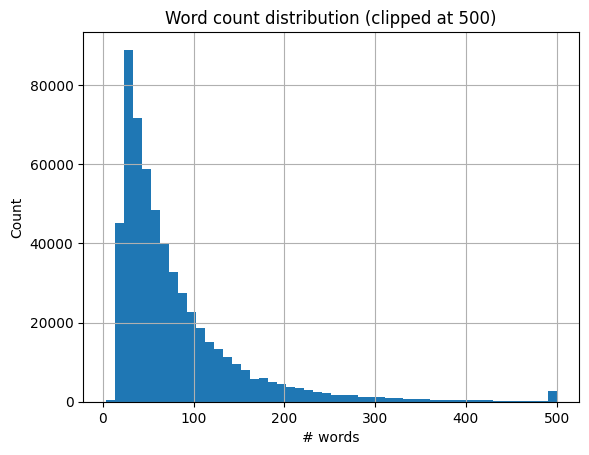

NEG median words: 64
NEU median words: 70
POS median words: 54


In [50]:
df["n_chars"] = df["text"].str.len()
df["n_words"] = df["text"].str.split().apply(len)

print(df[["n_chars","n_words"]].describe(percentiles=[.5,.9,.95,.99]).round(1))

plt.figure()
df["n_words"].clip(upper=500).hist(bins=50)   # clip to tidy very long tails
plt.title("Word count distribution (clipped at 500)")
plt.xlabel("# words")
plt.ylabel("Count")
plt.show()

# By class (quick glance)
for k,v in label2name.items():
    sub = df[df["label"]==k]["n_words"].clip(upper=500)
    print(v, "median words:", int(sub.median()))


In [39]:
df_sample = df.sample(10000, random_state=42)

In [40]:
# 4) Split
X_train, X_val, y_train, y_val = train_test_split(
    df_sample["text"], df_sample["label"],
    test_size=0.2, stratify=df_sample["label"], random_state=42
)

In [41]:
# 5) Baseline pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=-1))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    n_jobs=-1))])

In [42]:
# 6) Evaluate
pred = pipe.predict(X_val)
print("Baseline accuracy:", accuracy_score(y_val, pred))
print(classification_report(y_val, pred, target_names=["NEG","NEU","POS"], digits=3))

Baseline accuracy: 0.813
              precision    recall  f1-score   support

         NEG      0.603     0.657     0.629       280
         NEU      0.283     0.360     0.317       150
         POS      0.923     0.884     0.903      1570

    accuracy                          0.813      2000
   macro avg      0.603     0.634     0.616      2000
weighted avg      0.830     0.813     0.821      2000



In [43]:
df_sample["label"].value_counts(normalize=True)




2    0.7852
0    0.1398
1    0.0750
Name: label, dtype: float64

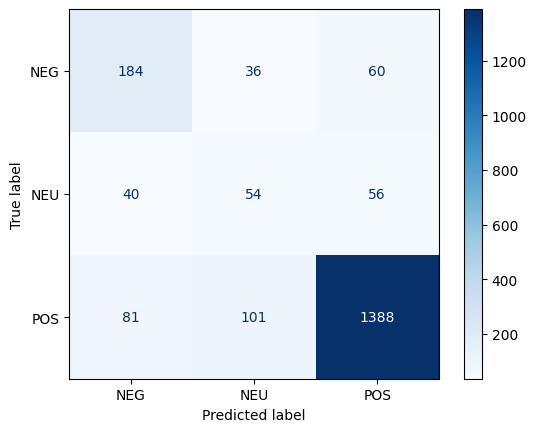

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["NEG","NEU","POS"])
disp.plot(cmap="Blues", values_format="d")
plt.show()


In [45]:
val_df = pd.DataFrame({"text": X_val, "true": y_val, "pred": pred})
mistakes = val_df[val_df["true"] != val_df["pred"]]
print(mistakes.sample(10, random_state=42))


                                                     text  true  pred
394183  This gluten free cereal is pretty good. It has...     2     1
291382  I received this product from a friend of mine ...     2     1
6089    Packed poorly in shipping and a few had the se...     2     0
99809   This is a nice change from using powdered stev...     2     0
524107  I thought that this popcorn would taste like a...     2     1
352130  I have one cup a day and it really decreases m...     2     1
180780  I think Snapple makes great products. I especi...     2     1
430608  This hot sauce has become a staple in my kitch...     2     1
157807  Still in process of narrowing down my personal...     2     1
97597   Very pleased with this. Good lavender flavor, ...     2     1


In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2))),
    ("nb", MultinomialNB())
])

pipe_nb.fit(X_train, y_train)
pred_nb = pipe_nb.predict(X_val)

print("Naive Bayes accuracy:", accuracy_score(y_val, pred_nb))
print(classification_report(y_val, pred_nb, target_names=["NEG","NEU","POS"], digits=3))


Naive Bayes accuracy: 0.785
              precision    recall  f1-score   support

         NEG      0.000     0.000     0.000       280
         NEU      0.000     0.000     0.000       150
         POS      0.785     1.000     0.880      1570

    accuracy                          0.785      2000
   macro avg      0.262     0.333     0.293      2000
weighted avg      0.616     0.785     0.690      2000



/Users/hamidabdul/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamidabdul/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamidabdul/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
